# Expectation Maximization

In this recap session we will explore the Expectation Maximization (EM) algorithm.

## Recap: The EM Algorithm
### The Problem Setting
We have a **generative model** $p_{\boldsymbol \theta}(\boldsymbol x, \boldsymbol z)$ specifying the joint probability distribution over **two types of random variables**:
- $\boldsymbol x$: **observed** random variables, i.e., we have i.i.d. data $\mathcal D_x = \left\{ \boldsymbol x_i \right\}_{i=1}^N$ for them, and
- $\boldsymbol z$: **latent** random variables, i.e., we do not have data for them.

We want to **fit the parameters** $\boldsymbol \theta$ of our model to the data $\mathcal D_x$.

### The Objective
Here, we are interested in fitting the parameters using the **maximum likelihood** recipe, i.e.,
- compute the likelihood of the data under our model
- adjust the parameters s.t. this likelihood is maximized.

### The Marginal Likelihood
As we have only data for $\boldsymbol x$, but not for $\boldsymbol z$, we **cannot use the full-data likelihood**,
$$ p_{\boldsymbol \theta}(\boldsymbol z_{1:N}, \boldsymbol x_{1:N}) = \prod_{n=1}^N p_{\boldsymbol \theta}(\boldsymbol z_{n}, \boldsymbol x_{n}),$$

but only the **marginal likelihood**, i.e.,
$$p_{\boldsymbol \theta}(\boldsymbol x_{1:N}) = \int \dots \int p_{\boldsymbol \theta}(\boldsymbol z_{1:N}, \boldsymbol x_{1:N}) \, \mathrm d z_1 \dots \mathrm d z_N = \int \dots \int \prod_{n=1}^N p_{\boldsymbol \theta}(\boldsymbol z_n, \boldsymbol x_n) \, \mathrm d \boldsymbol z_1 \dots \mathrm d \boldsymbol z_N = \prod_{n=1}^N \int p_{\boldsymbol \theta}(\boldsymbol z, \boldsymbol x_n) \, \mathrm d z.$$

Thus, our aim is to determine
$$\theta^* = \arg \max_{\boldsymbol \theta} p_{\boldsymbol \theta}(\boldsymbol x_{1:N}).$$

### The Log Marginal Likelihood
As always, numerics forces us to **work in log-probability space** (we have the product of many small positive numbers which causes underflow). Thus, we actually maximize the log marginal probability, i.e., 
$$\log p_{\boldsymbol \theta}(\boldsymbol x_{1:N}) = \sum_{n=1}^N \log \int p_{\boldsymbol \theta}(\boldsymbol z, \boldsymbol x_n) \, \mathrm d z.$$

### The Problem
Compare this optimization problem to what we studied before. We learned that maximum likelihood estimation works well for models from the exponential family because the logarithm cancels the exponential and we end up with a simple convex optimization problem that we can optimize with gradient descent. Here, however, the **marginal likelihood is not a member of the exponential family** which leads to a **complex, non-convex optimization problem** which is hard to optimize directly using gradient descent ("the logarithm is outside of the integral").

### The Solution: Expectation Maximization
In order to arrive at a algorithm which is better suited for the optimization of latent variable models, we **decompose the log marginal likelihood** as follows:
$$\log p_{\boldsymbol \theta}(\boldsymbol x_{1:N}) = \underbrace{\sum_{n=1}^N \mathbb E_{q_n(z)} \left[\log p_{\boldsymbol \theta} (\boldsymbol z, \boldsymbol x_n) - \log q_n(\boldsymbol z) \right]}_{\text{Evidence lower bound (ELBO): } \mathcal L(q_{1:N}, \boldsymbol \theta)} + \underbrace{\sum_{n=1}^N \mathrm{KL}\left[q_n(\boldsymbol z) || p(\boldsymbol z | \boldsymbol x_n) \right]}_{\geq 0}.$$
Note that this decomposition is valid for any set of **variational distributions** $q_{1:N}(\boldsymbol z)$. We observe that in the ELBO the logarithm now appears directly in front of the model distribution $p_{\boldsymbol \theta} (\boldsymbol z, \boldsymbol x_n)$, which now allows for a quite **simple optimization of the lower bound** (it is just a weighted maximum likelihood problem). Indeed, the **expectation maximization (EM) algorithm** proceeds iteratively:
- **Initialize** the parameters $\boldsymbol \theta$, e.g., randomly.
- **E-step**: Holding the model parameters $\boldsymbol \theta$ fixed, set the KL-term to zero, i.e., tighten the bound, by setting $q_n(\boldsymbol z) = p(\boldsymbol z | \boldsymbol x_n)$ for all $n \in \left\{1, \dots, N \right\}$.
- **M-step**: Holding the variational distribtuions $q_n$ fixed, maximize the lower bound w.r.t. $\boldsymbol \theta$.
- **Iterate** the E- and M-steps until convergence (i.e., until the marginal likelihood does not change anymore). As the E-step does not alter log marginal likelihood and the M-step necessarily increases it (the bound is tight before the M-step), EM is provably convergent.

### When is EM applicable?
To apply EM, we have to be able to perform the E- and M-steps. While the M-step is simple for **exponential family distributions** (weighted maximum likelihood), the E-step is only tractable for a quite limited range of problems, including models with **discrete latent variables** (e.g., Gaussian mixture models (GMMs)) or **linear Gaussian models** (e.g., probabilistic PCA). In more complex cases (such as the variational autoencoder), the E-step can only be approximately solved, which still works very well in practice (we lose the convergence guarantees, though).

# EM for Gaussian Mixtures

If we plug in a **discrete mixture of Gaussian distributions (GMM)**, i.e., $$p_{\boldsymbol \theta} (\boldsymbol x) = \sum_{k=1}^K p(z=k) \mathcal N(\boldsymbol x | \boldsymbol \mu_k, \boldsymbol \Sigma_k)$$ with $\boldsymbol \theta = \left[ p(z=1:K), \boldsymbol \mu_{1:K}, \boldsymbol \Sigma_{1:K} \right]$ into the EM-equations we arrive at:
- **E-step**: $$q_n(z=k) = p(z=k | \boldsymbol x_n) = \frac{p(z=k) \mathcal N(\boldsymbol x_n | \boldsymbol \mu_k, \boldsymbol \Sigma_k)}{\sum_{k'=1}^K p(z=k') \mathcal N(\boldsymbol x | \boldsymbol \mu_{k'}, \boldsymbol \Sigma_{k'})}.$$ In the case of GMMs, these distributions are called **"responsibilities"**, as they give the probabilities that the data point $\boldsymbol x_n$ was generated by component $k$.
- **M-step**:
\begin{align}
p^{\text{new}}(z = k) &= \frac{N_k}{N}, \\
\boldsymbol \mu_k^{\text{new}} &= \frac 1 {N_k} \sum_{n=1}^N q_n(z=k) \boldsymbol x_n, \\
\boldsymbol \Sigma_k^{\text{new}} &= \frac 1 {N_k} \sum_{n=1}^N q_n(z=k) (\boldsymbol x_n - \boldsymbol \mu_k^{\text{new}}) (\boldsymbol x_n - \boldsymbol \mu_k^{\text{new}})^T,
\end{align}
where $N_k = \sum_{n=1}^N q_n(z=k)$.

We are now going to **visualize the EM algorithm for GMMs**. Let us first load relevant functionality.

In [1]:
import numpy as np
from matplotlib import pyplot as plt  # NOTE: requires matplotlib >= 3.5
from em_util import visualize_em_gmm, initialize_gmm, e_step_gmm, m_step_gmm, compute_log_marginal_likelihood_gmm, compute_elbo_gmm, compute_kl_term_gmm
%matplotlib inline

Now let us load and **visualize the dataset**.

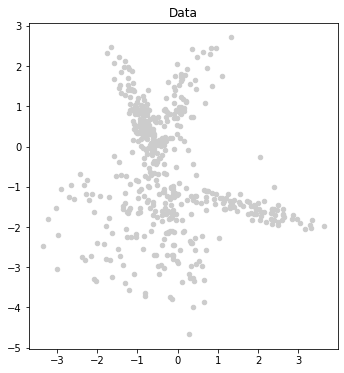

In [2]:
# choose one of the following four dataset
# X = np.load("samples_1.npy")
X = np.load("samples_2.npy")
# X = np.load("samples_3.npy")
# X = np.load("samples_u.npy")
visualize_em_gmm(X=X)

Now, we **initialize a GMM** with $K$ components and visualize this initial configuration.

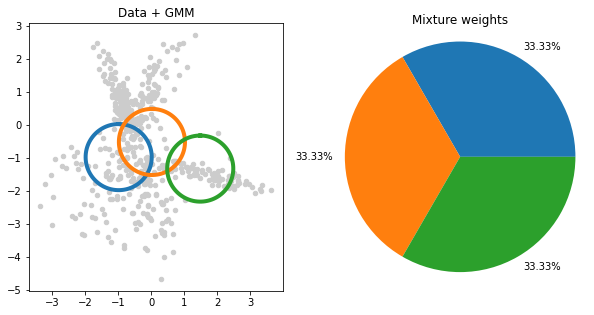

In [3]:
K = 3  # number of GMM components
log_marginal_likelihoods = [] # we log the log marginal likelihood values after every M-step
log_weights, means, covariances = initialize_gmm(n_components=K, d_x=X.shape[1])
log_marginal_likelihoods.append(compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances))
visualize_em_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances)

Let us now **compute and visualize the initial responsibilities**.

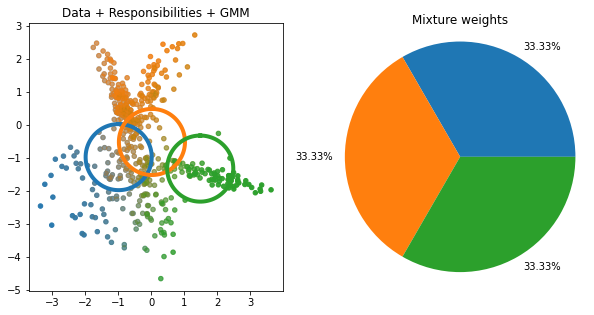

In [4]:
log_responsibilities = e_step_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances) 
visualize_em_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

Note that the responsibilities give **soft assignments** of the datapoints to the three components ("clusters"), indicated by coloring each datapoint in proportion to the responsibilities. As we just performed the E-step, the ELBO should be tight. Let us check that explicitly!

In [5]:
log_marginal_likelihood = compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances)
elbo = compute_elbo_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)
kl_term = compute_kl_term_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

print(f"log_marginal_likelihood = {log_marginal_likelihood:.4f}")
print(f"elbo                    = {elbo:.4f}")
print(f"kl_term                 = {kl_term:.4f}")
print(f"elbo + kl_term          = {elbo+kl_term:.4f}")

log_marginal_likelihood = -1786.8888
elbo                    = -1786.8888
kl_term                 = 0.0000
elbo + kl_term          = -1786.8888


Indeed, the KL-term vanishes, and consequently the **ELBO is tight**. Now let us **perform one update step** (M-step) of the GMM parameters.

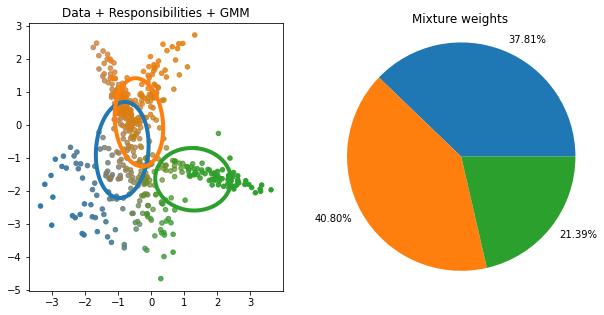

In [6]:
log_weights, means, covariances = m_step_gmm(X=X, log_responsibilities=log_responsibilities)
log_marginal_likelihoods.append(compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances))
visualize_em_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

Note that we **did not yet re-compute the responsibilities**, which is why in the plot above we still display the old soft assignments. Let us again check the decomposition of the log marginal likelihood.

In [7]:
log_marginal_likelihood = compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances)
elbo = compute_elbo_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)
kl_term = compute_kl_term_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

print(f"log_marginal_likelihood = {log_marginal_likelihood:.4f}")
print(f"elbo                    = {elbo:.4f}")
print(f"kl_term                 = {kl_term:.4f}")
print(f"elbo + kl_term          = {elbo+kl_term:.4f}")

log_marginal_likelihood = -1599.9059
elbo                    = -1619.0012
kl_term                 = 19.0953
elbo + kl_term          = -1599.9059


Note that the **M-step increased the log-marginal likelihood**. Furthermore, the **bound is not tight anymore**, as we did not yet re-compute the responsibilities. Thus, let us again **re-compute the responsibilities**.

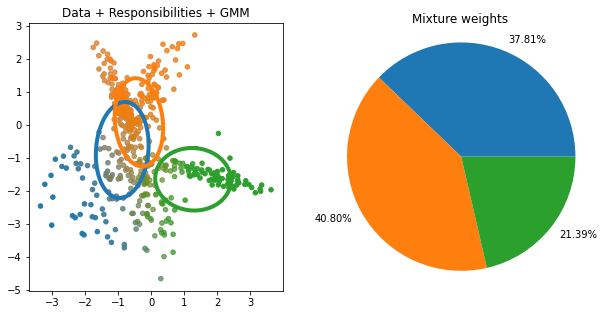

In [8]:
log_responsibilities = e_step_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances) 
visualize_em_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

As expected, the **bound is now tight again**:

In [9]:
log_marginal_likelihood = compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances)
elbo = compute_elbo_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)
kl_term = compute_kl_term_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

print(f"log_marginal_likelihood = {log_marginal_likelihood:.4f}")
print(f"elbo                    = {elbo:.4f}")
print(f"kl_term                 = {kl_term:.4f}")
print(f"elbo + kl_term          = {elbo+kl_term:.4f}")

log_marginal_likelihood = -1599.9059
elbo                    = -1599.9059
kl_term                 = 0.0000
elbo + kl_term          = -1599.9059


Also note that the **E-step did not change the value of the log marginal likelihood**! Now, we can **perform some more iterations of E-step -- M-step** and visualize the final result.

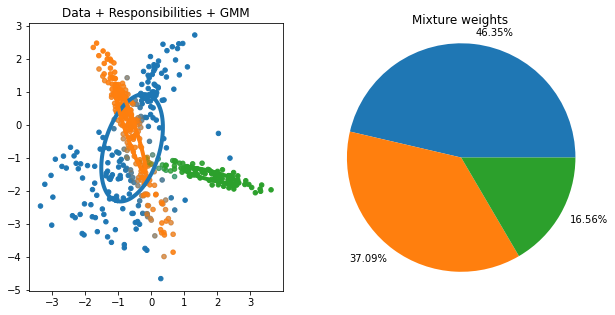

In [10]:
n_iter = 100
for _ in range(n_iter - 1): # we already performed one iteration manually
    log_weights, means, covariances = m_step_gmm(X=X, log_responsibilities=log_responsibilities)
    log_marginal_likelihoods.append(compute_log_marginal_likelihood_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances))
    log_responsibilities = e_step_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances) 
visualize_em_gmm(X=X, log_weights=log_weights, means=means, covariances=covariances, log_responsibilities=log_responsibilities)

Finally, let us **check convergence** by looking at the log marginal likelihood values over the iterations:

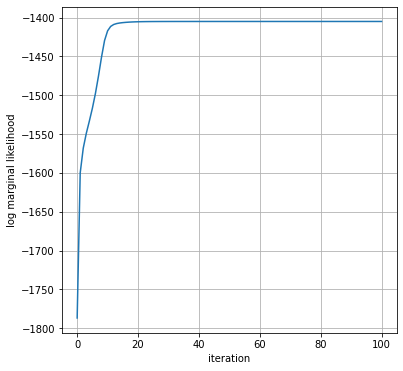

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax.plot(log_marginal_likelihoods)
ax.set_xlabel("iteration")
ax.set_ylabel("log marginal likelihood")
ax.grid()

Obviously, the EM algorithm did converge!